In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [4]:
indir = "outfiles/notrigger/chunksize100000/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)

started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum['templates'] = out['templates']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'].add(out['templates'])
            outsum['sumw'].add(out['sumw'])
    
        del out

Loading outfiles/notrigger/chunksize100000/2017_dask_data.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_higgs.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_qcd.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_top.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_wandvv.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_z.coffea


In [5]:
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [15]:
templates.values()

{('ZH',
  'signal'): array([[[[0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00]],
 
         [[5.44397363e-03, 3.26591616e-08],
          [9.29398220e-03, 0.00000000e+00],
          [7.35135979e-03, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00]],
 
         [[1.38253977e-02, 0.00000000e+00],
          [2.07906007e-02, 0.00000000e+00],
          [3.82174317e-03, 0.00000000e+00],
          ...,
          [8.57900980e-13, 0.00000000e+00],
          [9.33984186e-04, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00]],
 
         ...,
 
         [[1.58742471e-03, 0.00000000e+00],
          [6.61011936e-04, 0.00000000e+00],
          [1.25075688e-04, 0.0

In [6]:
h = templates.integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(350,1200)).integrate('ddb1',int_range=slice(0.64,1))

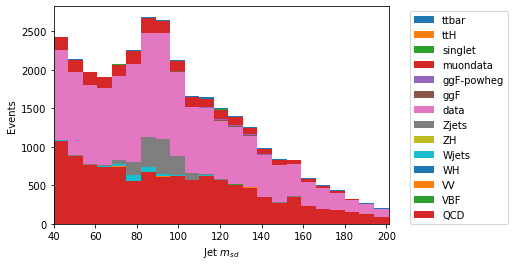

In [7]:
hist.plot1d(h,stack='process')
plt.legend(bbox_to_anchor=(1.05,1))

In [8]:
processes = [t[0] for t in templates.values().keys() if t[1] == 'signal']
processes

['ZH',
 'WH',
 'ttH',
 'VBF',
 'ggF',
 'ggF-powheg',
 'QCD',
 'VV',
 'Wjets',
 'Zjets',
 'ttbar',
 'singlet',
 'data',
 'muondata']

In [13]:
pt = 450
fout = uproot3.create('signalregion_pt{0}.root'.format(pt))
for ddb_region in ['pass', 'fail']:
    if ddb_region == 'pass':
        ddb_l = 0.64
        ddb_r = 1
        ext = "_pass"
    elif ddb_region == 'fail':
        ddb_l = 0
        ddb_r = 0.64
        ext = "_fail"
            
    h = templates.integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
    
    for process in processes:
        print(process, end="")
        fout[process + ext] = hist.export1d(h[process].sum('process'))
        print("...done")
fout.close()

ZH...done
WH...done
ttH...done
VBF...done
ggF...done
ggF-powheg...done
QCD...done
VV...done
Wjets...done
Zjets...done
ttbar...done
singlet...done
data...done
muondata...done
ZH...done
WH...done
ttH...done
VBF...done
ggF...done
ggF-powheg...done
QCD...done
VV...done
Wjets...done
Zjets...done
ttbar...done
singlet...done
data...done
muondata...done
